# Steady-state Ligand-Receptor inference

`liana` provides different statistical methods to infer `ligand-receptor` interactions from single-cell transcriptomics data omics data using prior knowledge.
In this notebook we showcase how to use liana in its most basic form with toy data.

We also refer users to the [Cell-cell communication chapter](https://www.sc-best-practices.org/mechanisms/cell_cell_communication.html) in the [best-practices guide from Theis lab](https://www.nature.com/articles/s41576-023-00586-w). There we provide an overview of the common limitations and assumptions in CCC inference from (dissociated single-cell) transcriptomics data.

lianaは、単一細胞のトランスクリプトミクスデータやオミックスデータから、事前知識を用いてリガンドと受容体の相互作用を推測するための様々な統計的手法を提供します。このノートブックでは、おもちゃのデータを使ったlianaの最も基本的な使い方を紹介する。

また、Theis研究室のベストプラクティスガイドのCell-cell communicationの章も参照してください。そこでは、（解離した単一細胞の）トランスクリプトミクスデータからのCCC推論における一般的な限界と仮定の概要を説明しています。

## Loading Packages

In [1]:
# needed for visualization and toy data
import scanpy as sc

In [2]:
# import liana
import liana as li

In [18]:
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)

## Loading toy data

In the most general case, `liana`'s ligand-receptor methods use `anndata` objects with processed single-cell transcriptomics data, with pre-defined cell labels (identities), to infer ligand-receptor interactions among all pairs of cell identities.

To load the example data-set, simply run:

最も一般的なケースでは、lianaのリガンド-レセプターメソッドは、事前に定義された細胞ラベル（identity）を持つ、シングルセルのトランスクリプトミクスデータを処理したanndataオブジェクトを使い、細胞のidentityの全てのペア間のリガンド-レセプター相互作用を推測する。

サンプルのデータセットをロードするには、単純に実行する：

In [3]:
adata = sc.datasets.pbmc68k_reduced()

In [4]:
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [5]:
adata.obs.head()

,bulk_labels,n_genes,percent_mito,n_counts,S_score,G2M_score,phase,louvain
index,,,,,,,,
AAAGCCTGGCTAAC-1,CD14+ Monocyte,1003,0.023856,2557.0,-0.119160,-0.816889,G1,1
AAATTCGATGCACA-1,Dendritic,1080,0.027458,2695.0,0.067026,-0.889498,S,1
AACACGTGGTCTTT-1,CD56+ NK,1228,0.016819,3389.0,-0.147977,-0.941749,G1,3
AAGTGCACGTGCTA-1,CD4+/CD25 T Reg,1007,0.011797,2204.0,0.065216,1.469291,G2M,9
ACACGAACGGAGTG-1,Dendritic,1178,0.017277,3878.0,-0.122974,-0.868185,G1,2


In [6]:
adata.var.head()

,n_counts,means,dispersions,dispersions_norm,highly_variable
index,,,,,
HES4,1153.387451,0.592365,2.028047,2.771764,True
TNFRSF4,304.358154,0.193332,1.760724,2.746426,True
SSU72,2530.272705,1.019981,1.208284,-0.631160,False
PARK7,7451.664062,1.828078,1.288261,-0.544716,False
RBP7,272.811035,0.174943,1.842789,3.192285,True


The example single-cell data consists processed data with PBMCs cell types

シングルセルデータの例は、PBMCの細胞タイプで処理されたデータで構成されている。

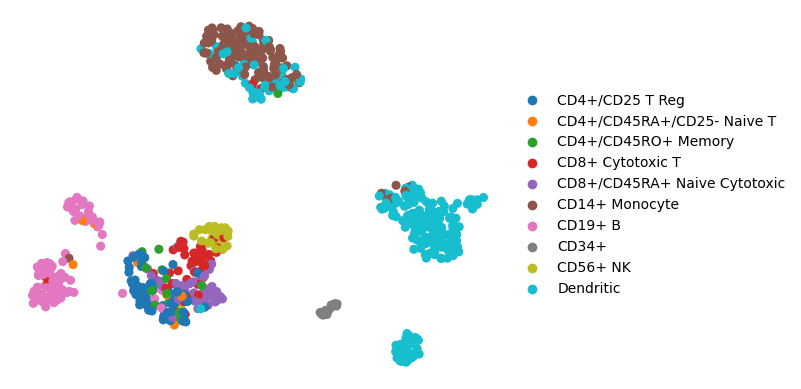

In [8]:
sc.pl.umap(adata, color='bulk_labels', title='', frameon=False)

## Background

`liana` typically works with the log1p-trasformed counts matrix, in this object the normalized counts are stored in `raw`:

liana は通常、log1p-trasformed counts 行列で動作し、このオブジェクトでは正規化されたカウントが raw で格納されます：

In [9]:
adata.raw.X

<700x765 sparse matrix of type '<class 'numpy.float32'>'
	with 174400 stored elements in Compressed Sparse Row format>

Preferably, one would use `liana` with all features (genes) for which we have enough counts, but for the sake of this tutorial we are working with a matrix pre-filtered to the variable features alone.

In the background, `liana` aggregates the counts matrix and generates statistics, typically related to cell identies.
These statistics are then utilized by each of the methods in `liana`.

できれば、十分なカウント数がある全ての特徴（遺伝子）に対して liana を使いたいところだが、このチュートリアルでは、あらかじめ変数特徴だけにフィルターをかけたマトリックスを使っている。

バックグラウンドで、lianaはカウント行列を集約し、統計量を生成する。これらの統計量はlianaの各メソッドで利用される。

### Methods

In [10]:
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...
0,scSeqComm,inter_score,None,"Baruzzo, G., Cesaro, G., Di Camillo, B. 2022. ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."


Each method infers relevant ligand-receptor interactions relying on different assumptions and each method returns different ligand-receptor scores, typically a pair per method. One score corresponding to
the `magnitude` (strength) of interaction and the other reflecting how `specificity` of a given interaction to a pair cell identities.

Methods in liana are **callable** instances of the `Method` class. To obtain further information for each method the user can refer to the methods documentation `?method_name` or `?method.__call__`. Alternatively, users can use the `method.describe` function to get a short summary for each method.

For example, if the user wishes to learn more about liana's `rank_aggregate` implementation, where we combine the scores of multiple methods, they could do the following: 

各手法はそれぞれ異なる仮定に基づき、関連するリガンド-レセプター相互作用を推論し、各手法は異なるリガンド-レセプタースコアを返す。一方のスコアは相互作用の大きさ（強さ）に対応し、もう一方のスコアは与えられた相互作用がどの程度特異的であるかを、一対の細胞IDに反映する。

lianaのメソッドはMethodクラスの呼び出し可能なインスタンスである。各メソッドの詳細な情報を得るために、ユーザーはメソッドドキュメントの?method_nameや?method.__call__を参照することができます。また、method.describe 関数を使用して、各メソッドの簡単な概要を取得することもできます。

例えば、ユーザーがlianaのrank_aggregateの実装についてもっと知りたい場合、複数のメソッドのスコアを組み合わせるのですが、次のようにします：

In [11]:
# import liana's rank_aggregate
from liana.mt import rank_aggregate

In [14]:
?rank_aggregate.__call__

Signature:
rank_aggregate.__call__(
    adata: 'an.AnnData | MuData',
    groupby: 'str',
    resource_name: 'str' = 'consensus',
    expr_prop: 'float' = 0.1,
    min_cells: 'int' = 5,
    groupby_pairs: 'Optional[DataFrame]' = None,
    base: 'float' = 2.718281828459045,
    aggregate_method: 'str' = 'rra',
    consensus_opts: 'Optional[list]' = None,
    return_all_lrs: 'bool' = False,
    key_added: 'str' = 'liana_res',
    use_raw: 'Optional[bool]' = True,
    layer: 'Optional[str]' = None,
    de_method: 'str' = 't-test',
    n_perms: 'int' = 1000,
    seed: 'int' = 1337,
    n_jobs: 'int' = 1,
    resource: 'Optional[DataFrame]' = None,
    interactions: 'Optional[list]' = None,
    mdata_kwargs: 'dict' = {},
    inplace: 'bool' = True,
    verbose: 'Optional[bool]' = False,
)
Docstring:
Get an aggregate of ligand-receptor scores from multiple methods.

Parameters
----------
adata
    Annotated data object.
groupby
    Key to be used for grouping.
resource_name
    Name of the r

or alternatively:

あるいはその代わりに

In [15]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`. magnitude_rank and specificity_rank respectively represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.


## By default, LIANA+ uses **human gene symbols**. See the documentation and the [Prior Knowledge vignette](https://liana-py.readthedocs.io/en/latest/notebooks/prior_knowledge.html) for details and instructions for homology conversion.


## Example Run

### Individual Methods

In [16]:
# import all individual methods
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

LIANA will by default use the `.raw` attribute of AnnData. If you wish to use .X set `use_raw` to `False`, or specify a `layer`.

LIANA will also by default use the 'consensus' resource to infer ligand-receptor interactions. 
This resource was created as a consensus from the resources literature-curated resources in OmniPath, and uses **human gene symbols**.

For different species, we provide 'mouseconsensus', for any other species you can provide your own resource, or translate LIANA's resources via [decoupler](https://decoupler-py.readthedocs.io/en/latest/notebooks/translate.html).

If you wish to use a different resource, please specify it via the `resource_name` parameter for internal resources, or provide an external one via `resource` or `interactions`.

LIANAは、デフォルトでAnnDataの.raw属性を使用する。.Xを使いたい場合は、use_rawをFalseに設定するか、レイヤーを指定する。

LIANAはまた、リガンドとレセプターの相互作用を推測するために、デフォルトで'consensus'リソースを使う。このリソースはOmniPathの文献キュレーションされたリソースからコンセンサスとして作成され、ヒトの遺伝子シンボルを使用する。

異なる生物種については、我々は'mouseconsensus'を提供しており、他の生物種については、独自のリソースを提供するか、decouplerを介してLIANAのリソースを翻訳することができる。

別のリソースを使いたい場合は、内部リソースではresource_nameパラメータで指定し、外部リソースではresourceまたはinteractionsで指定してください。

In [19]:
# run cellphonedb
cellphonedb(
    adata,
    groupby='bulk_labels',
    # NOTE by default the resource uses HUMAN gene symbols
    resource_name='consensus',
    expr_prop=0.1,
    verbose=True, key_added='cpdb_res'
)

Using resource `consensus`.
Using `.raw`!
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 700 samples and 43 features


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.44it/s]


In [37]:
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'cpdb_res', 'liana_res'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

By default, liana will be run **inplace** and results will be assigned to `adata.uns['liana_res']`.
Note that the high proportion of missing entities here is expected, as we are working on the reduced dimensions data.

デフォルトでは、lianaはインプレースで実行され、結果はadata.uns['liana_res']に割り当てられる。ここでは、欠損エンティティの割合が高いことが予想されます。

In [20]:
# by default, liana's output is saved in place:
adata.uns['cpdb_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
482,HLA-DRA,HLA-DRA,4.537684,0.995833,CD4,CD4,0.612842,0.421053,Dendritic,CD4+/CD45RO+ Memory,2.575263,0.0
321,HLA-DRA,HLA-DRA,4.537684,0.995833,CD4,CD4,0.596125,0.500000,Dendritic,CD4+/CD45RA+/CD25- Naive T,2.566905,0.0
989,HLA-DRA,HLA-DRA,4.537684,0.995833,CD4,CD4,0.483977,0.302326,Dendritic,CD14+ Monocyte,2.510830,0.0
651,HLA-DRA,HLA-DRA,4.537684,0.995833,LAG3,LAG3,0.399500,0.240741,Dendritic,CD8+ Cytotoxic T,2.468592,0.0
1392,HLA-DRA,HLA-DRA,4.537684,0.995833,CD4,CD4,0.373671,0.270833,Dendritic,Dendritic,2.455678,0.0


Here, we see that stats are provided for both ligand and receptor entities, more specifically: `ligand` and `receptor` are the two entities that potentially interact. As a reminder, CCC events are not limited to secreted signalling, but we refer to them as `ligand` and `receptor` for simplicity.

Also, in the case of heteromeric complexes, the `ligand` and `receptor` columns represent the subunit with minimum expression, while `*_complex` corresponds to the actual complex, with subunits being separated by `_`.

- `source` and `target` columns represent the source/sender and target/receiver cell identity for each interaction, respectively

- `*_props`: represents the proportion of cells that express the entity. 

  By default, any interactions in which either entity is not expressed in above 10% of cells per cell type is considered as a false positive,
  under the assumption that since CCC occurs between cell types, a sufficient proportion of cells within should express the genes.

- `*_means`: entity expression mean per cell type

- `lr_means`: mean ligand-receptor expression, as a measure of ligand-receptor interaction **magnitude**

- `cellphone_pvals`: permutation-based p-values, as a measure of interaction **specificity**

`ligand`, `receptor`, `source`, and `target` columns are returned by every ligand-receptor method, while the rest of the columns can vary across the ligand-receptor methods, as each method infers relies on different assumptions and scoring functions, and hence each returns different ligand-receptor scores. Nevertheless, typically most methods use a pair of scoring functions - where one often corresponds to the **magnitude** (strength) of interaction and the other reflects how **specificity** of a given interaction to a pair cell identities.

より具体的には、リガンドとレセプターは相互作用する可能性のある2つのエンティティである。注意点として、CCCイベントは分泌シグナルに限定されないが、簡単のためにリガンドとレセプターと呼ぶ。

また、ヘテロマー複合体の場合、リガンドとレセプターの列は最小発現量のサブユニットを表し、*_complex は実際の複合体に対応し、サブユニットは _ で区切られている。

- sourceとtargetの列は、それぞれ各相互作用のソース/センダー、ターゲット/レシーバーの細胞の同一性を表す。
- *_props: 実体を発現する細胞の割合を表す。
- デフォルトでは、CCCは細胞タイプ間で起こるので、細胞タイプ内の十分な割合の細胞が遺伝子を発現しているはずだという仮定のもと、細胞タイプごとに10％以上の細胞でどちらかの実体が発現していない相互作用は偽陽性とみなされる。
- *_means：細胞型ごとの実体発現の平均値
- lr_means：リガンド-受容体相互作用の大きさの指標としての、リガンド-受容体発現の平均値
- cellphone_pvals：相互作用の特異性の指標として、並べ替えに基づくp値

リガンド、レセプター、ソース、ターゲットのカラムはどのリガンド-レセプターメソッドでも返されますが、残りのカラムはリガンド-レセプターメソッドによって異なります。とはいえ、一般的にほとんどのメソッドは一対のスコアリング関数を使う - 一方は相互作用の大きさ（強さ）に対応することが多く、もう一方は与えられた相互作用が一対の細胞の同一性に対してどの程度特異的であるかを反映する。

#### Dotplot

We can now visualize the results that we just obtained.

LIANA provides some basic, but flexible plotting functionalities. Here, we will generate a dotplot of relevant ligand-receptor interactions.

今得た結果を可視化することができる。

LIANAには、いくつかの基本的な、しかし柔軟なプロット機能がある。ここでは、関連するリガンド-レセプター相互作用のドットプロットを作成する。

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


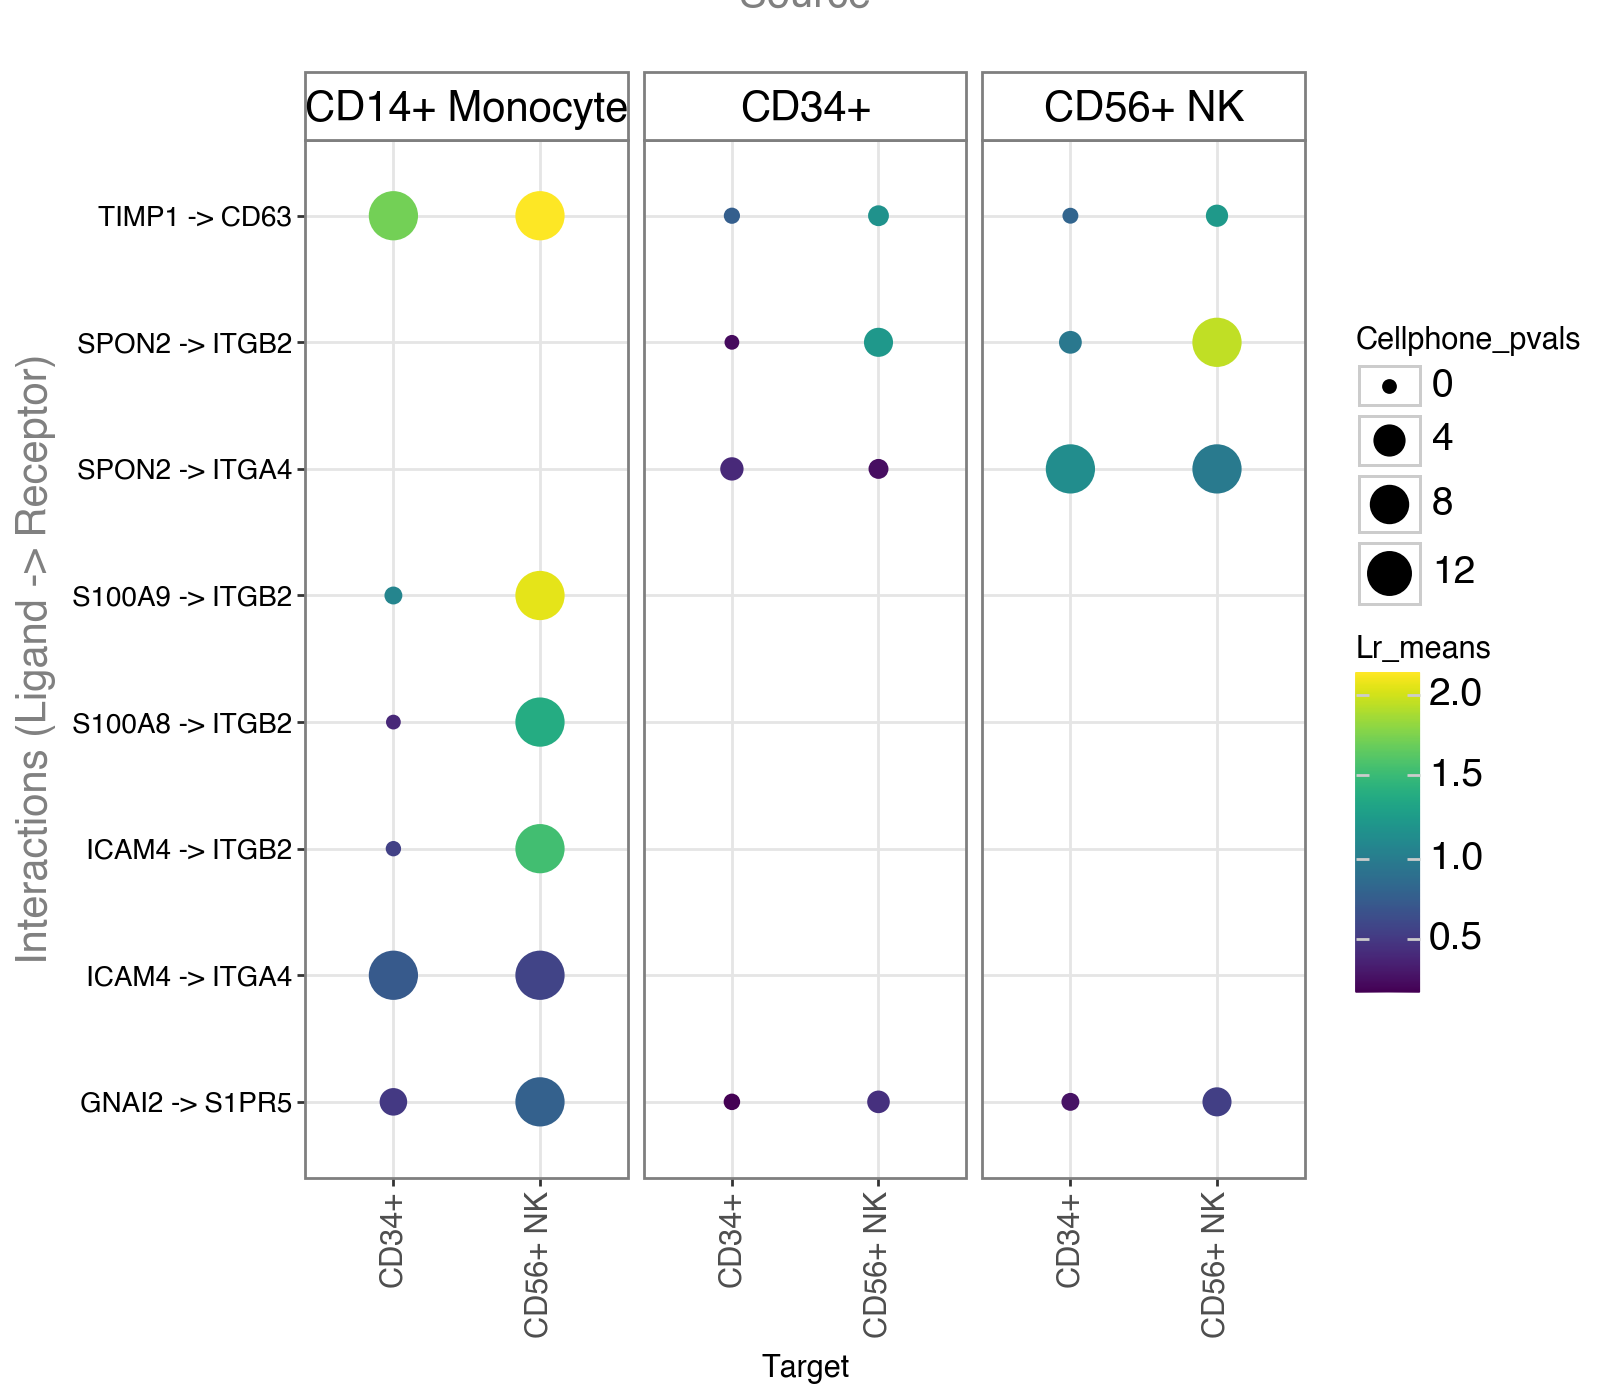

In [21]:
li.pl.dotplot(
    adata=adata,
    colour='lr_means',
    size='cellphone_pvals',
    inverse_size=True,  # we inverse sign since we want small p-values to have large sizes
    source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
    target_labels=['CD34+', 'CD56+ NK'],
    figure_size=(8, 7),
    # finally, since cpdbv2 suggests using a filter to FPs
    # we filter the pvals column to <= 0.05
    filter_fun=lambda x: x['cellphone_pvals'] <= 0.05,
    uns_key='cpdb_res'  # uns_key to use, default is 'liana_res'
)

Missing dots here would represent interactions for which the ligand and receptor are not expressed above the `expr_prop`. One can change this threshold by setting `expr_prop` to a different value. Alternatively, setting `return_all_lrs` to `True` will return all ligand-receptor interactions, regardless of expression.

ここでドットがない場合は、リガンドとレセプターが expr_prop を超えて発現していない相互作用を表します。expr_propを別の値に設定することで、この閾値を変更することができます。また、return_all_lrsをTrueに設定すると、発現に関係なく全てのリガンドとレセプターの相互作用を返します。

#### Tileplot

While dotplots are useful to visualize the most relevant interactions, LIANA's tileplots are more useful when visualizing the statistics of ligands and receptors, individually.

ドットプロットは最も関連性の高い相互作用を視覚化するのに便利だが、LIANAのタイルプロットは、リガンドとレセプターの統計量を個別に視覚化するのに便利である。

In [22]:
my_plot = li.pl.tileplot(
    adata=adata,
    # NOTE: fill & label need to exist for both
    # ligand_ and receptor_ columns
    fill='means',
    label='props',
    label_fun=lambda x: f'{x:.2f}',
    top_n=10,
    orderby='cellphone_pvals',
    orderby_ascending=True,
    source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
    target_labels=['CD34+', 'CD56+ NK'],
    uns_key='cpdb_res',  # NOTE: default is 'liana_res'
    source_title='Ligand',
    target_title='Receptor',
    figure_size=(8, 7)
)

/Users/tomoya/mambaforge/envs/py_scvi/lib/python3.10/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


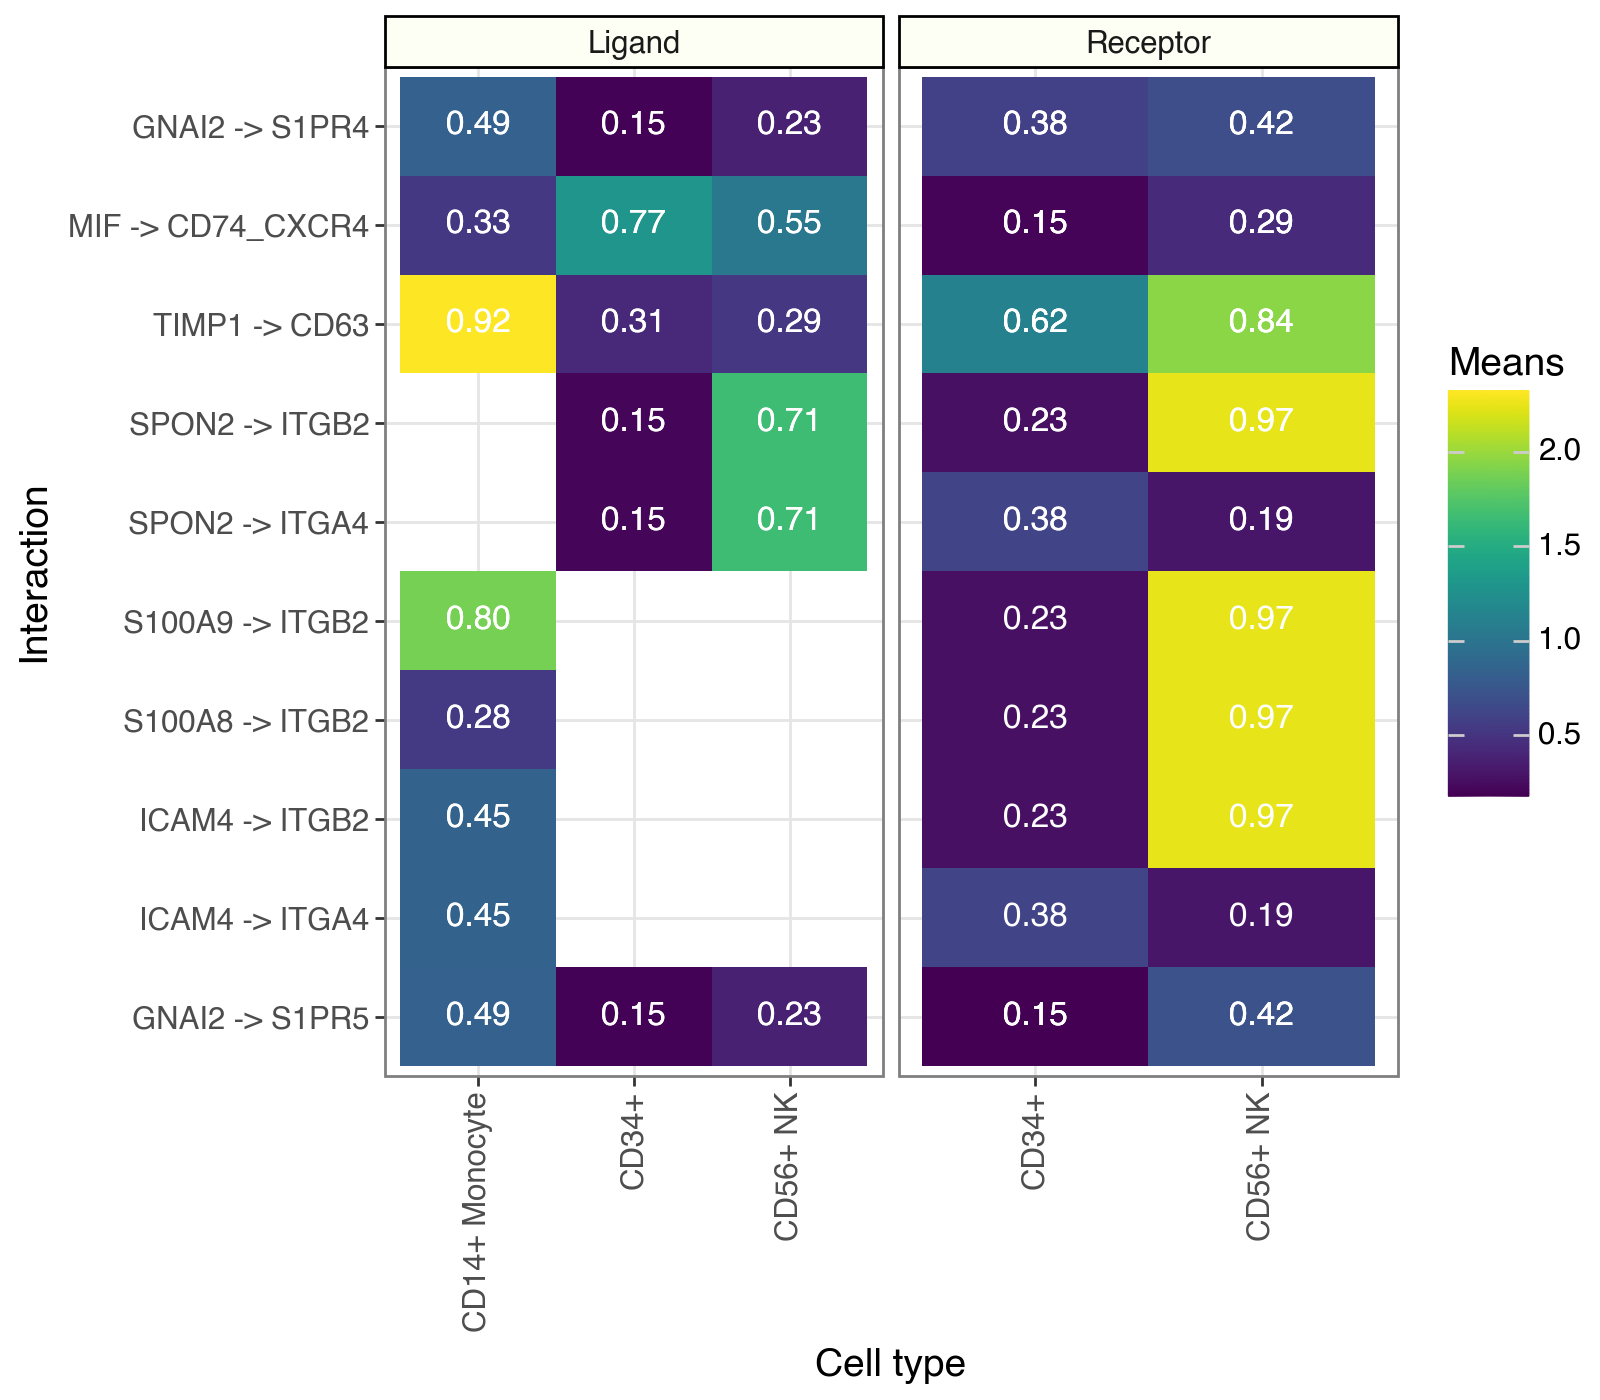

In [23]:
my_plot

### Rank Aggregate
In addition to the individual methods, LIANA also provides a consensus that integrates the predictions of individual methods.
This is done by ranking and aggregating ([RRA](https://academic.oup.com/bioinformatics/article-abstract/28/4/573/213339)) the ligand-receptor interaction predictions from all methods.

個々の手法に加えて、LIANAは個々の手法の予測を統合するコンセンサスも提供する。これは、すべての手法から得られたリガンド-受容体相互作用予測値をランキングし、集約（RRA）することによって行われる。

In [24]:
# Run rank_aggregate
li.mt.rank_aggregate(
    adata,
    groupby='bulk_labels',
    resource_name='consensus',
    expr_prop=0.1,
    verbose=True
)

Using resource `consensus`.
Using `.raw`!
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 700 samples and 43 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 343.86it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


In [38]:
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'cpdb_res', 'liana_res'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [25]:
adata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,specificity_rank,magnitude_rank
1209,Dendritic,CD4+/CD45RO+ Memory,HLA-DRA,CD4,2.575263,0.0,2.780884,0.723815,1.431302,0.065077,0.736772,0.001137,0.000653
1188,Dendritic,CD4+/CD45RA+/CD25- Naive T,HLA-DRA,CD4,2.566905,0.0,2.705027,0.709428,1.332656,0.063302,0.734081,0.001137,0.000911
1210,Dendritic,CD4+/CD45RO+ Memory,HLA-DRB1,CD4,2.415010,0.0,2.584465,0.712731,1.331341,0.060203,0.729607,0.001137,0.001211
1205,Dendritic,CD4+/CD45RO+ Memory,HLA-DPB1,CD4,2.367473,0.0,2.526199,0.731297,1.447014,0.068953,0.727352,0.001137,0.001377
1189,Dendritic,CD4+/CD45RA+/CD25- Naive T,HLA-DRB1,CD4,2.406652,0.0,2.513965,0.698344,1.232695,0.058561,0.726870,0.001137,0.001741


In [26]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`. magnitude_rank and specificity_rank respectively represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.


The remainder of the columns in this dataframe are those coming from each of the methods included in the `rank_aggregate` - i.e. see the `show_methods` to map methods to scores.

このデータフレームの残りの列は、rank_aggregateに含まれる各メソッドに由来するものである。
つまり、メソッドとスコアの対応付けはshow_methodsを参照してください。

#### Dotplot

We will now plot the most 'relevant' interactions ordered to the `magnitude_rank` results from aggregated_rank.

ここで、aggregated_rankから得られたmagnitude_rank順に、最も "関連性の高い "相互作用をプロットする。

/Users/tomoya/mambaforge/envs/py_scvi/lib/python3.10/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


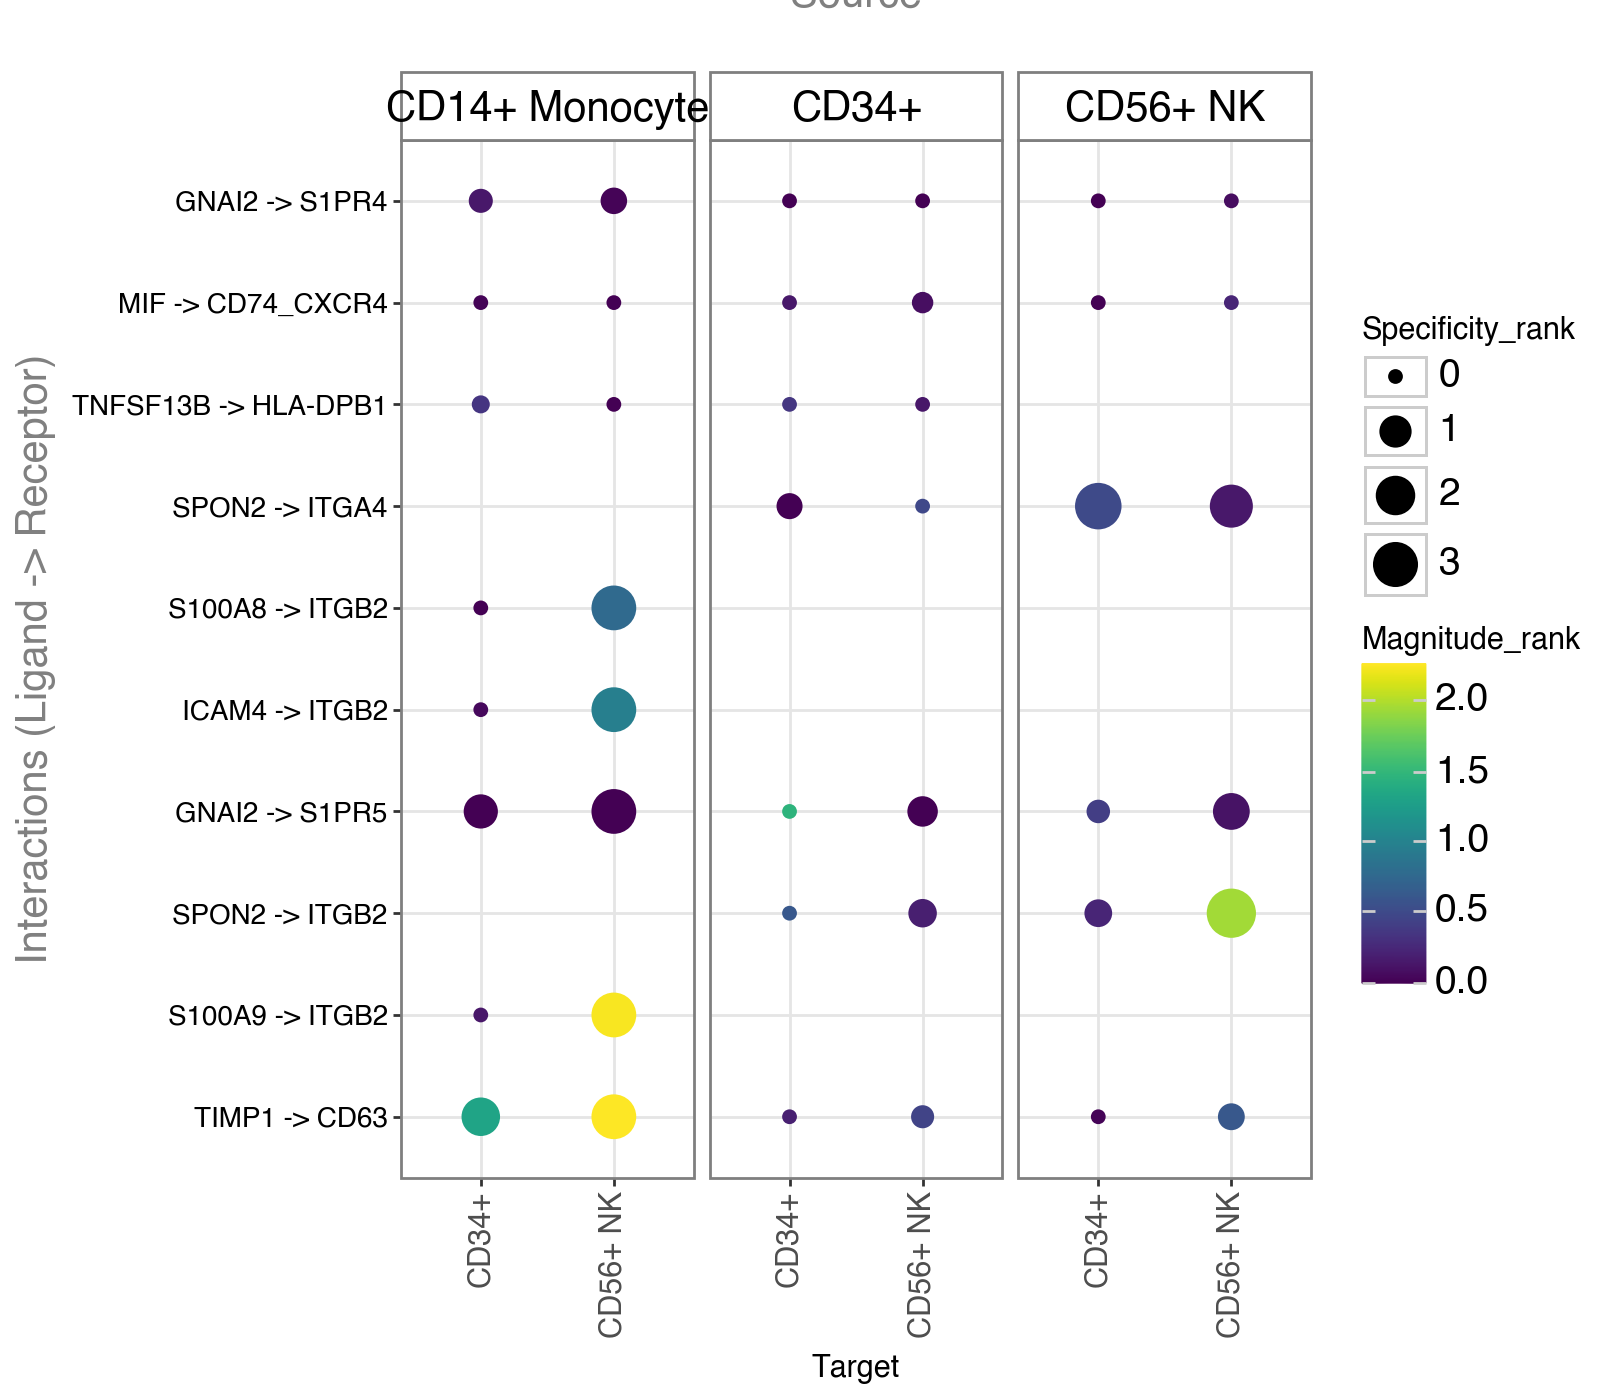

In [27]:
li.pl.dotplot(
    adata=adata,
    colour='magnitude_rank',
    size='specificity_rank',
    inverse_size=True,
    inverse_colour=True,
    source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
    target_labels=['CD34+', 'CD56+ NK'],
    top_n=10,
    orderby='magnitude_rank',
    orderby_ascending=True,
    figure_size=(8, 7)
)

Similarly, we can also treat the ranks provided by RRA as a probability distribution to which we can `filter` interactions
according to how robustly and highly ranked they are across the different methods.

同様に、RRAによって提供されたランクを確率分布として扱うこともでき、この確率分布によって、異なる方法にわたってどれだけ強固で高いランク付けがされているかによって、相互作用をフィルタリングすることができる。

In [28]:
my_plot = li.pl.dotplot(
    adata=adata,
    colour='magnitude_rank',
    inverse_colour=True,
    size='specificity_rank',
    inverse_size=True,
    source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
    target_labels=['CD34+', 'CD56+ NK'],
    filter_fun=lambda x: x['specificity_rank'] <= 0.01,
)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


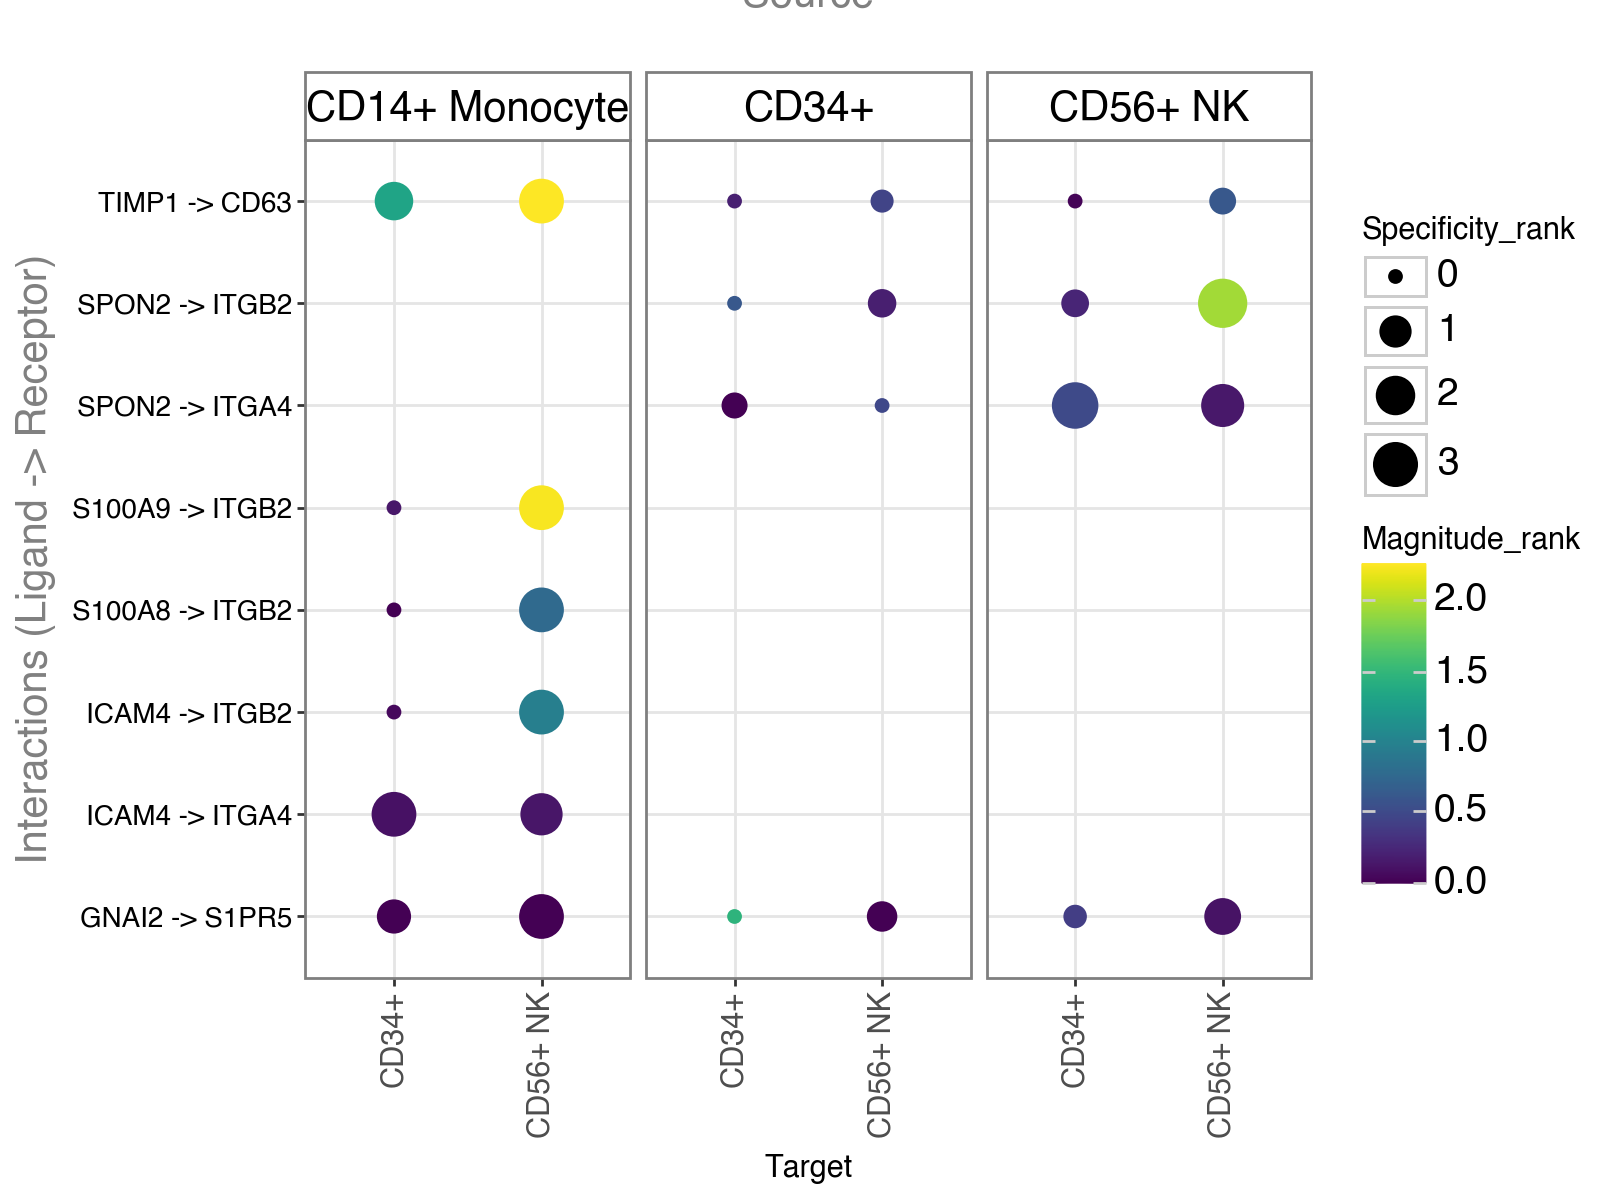

In [29]:
my_plot

Save the plot to a file:

プロットをファイルに保存する：

In [30]:
my_plot.save('dotplot.pdf')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


#### Customizing LIANA's Plots

Finally, the plots in liana are built with `plotnine` and their aesthetics can be easily modified. For example:

最後に、lianaのプロットはplotnineで作られており、その美観は簡単に変更できる。例えば

In [31]:
# we import plotnine
import plotnine as p9

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


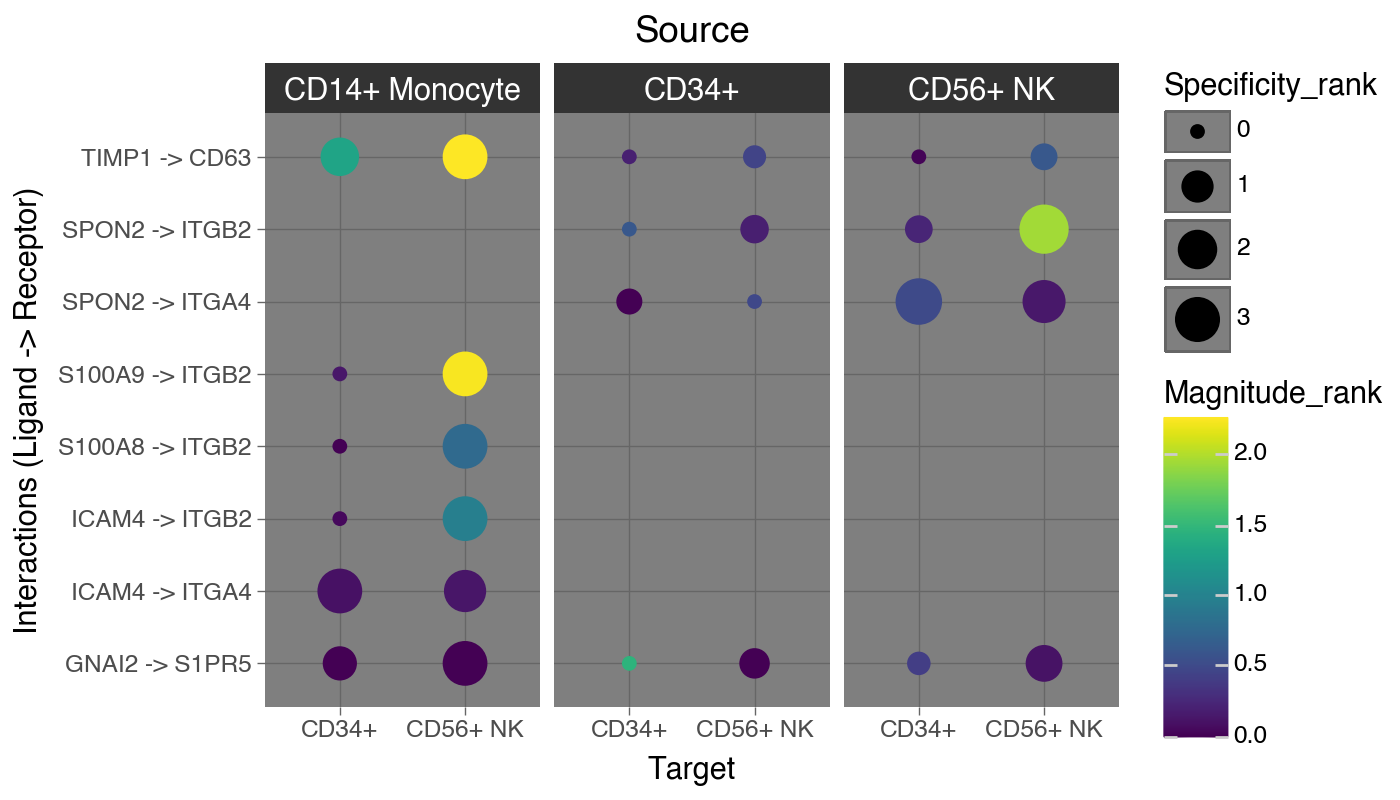

In [32]:
(
    my_plot +
        # change theme
        p9.theme_dark() +
        # modify theme
        p9.theme(
            # adjust facet size
            strip_text=p9.element_text(size=11),
            figure_size=(7, 4)
        )
)

For more plot modification options  we refer the user to `plotnine`'s tutorials
and to the following link for a quick intro: 
https://datacarpentry.org/python-ecology-lesson/07-visualization-ggplot-python/index.html.

より多くのプロット修正オプションについては、plotnineのチュートリアルを参照してください：

## Customizing LIANA's rank aggregate

LIANA's rank aggregate is also customizable, and the user can choose to include only a subset of the methods.

For example, let's generate a consensus with geometric mean and logfc methods only:

LIANAのランク集計はカスタマイズ可能であり、ユーザーは手法のサブセットだけを含めることもできる。

たとえば、幾何平均法とlogfc法だけを用いてコンセンサスを生成してみよう：

In [33]:
methods = [logfc, geometric_mean]

new_rank_aggregate = li.mt.AggregateClass(li.mt.aggregate_meta, methods=methods)

In [35]:
new_rank_aggregate(
    adata,
    groupby='bulk_labels',
    expr_prop=0.1,
    verbose=True,
    # Note that with this option, we don't perform permutations
    # and hence we exclude the p-value for geometric_mean, as well as specificity_rank
    n_perms=None,
    use_raw=True,
)

Using resource `consensus`.
Using `.raw`!
0.94 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 700 samples and 43 features
Assuming that counts were `natural` log-normalized!
Running log2FC
Running Geometric Mean


Check the results

結果を確認する

In [36]:
adata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_logfc,lr_gmeans,magnitude_rank
110,CD14+ Monocyte,CD56+ NK,TIMP1,CD63,1.435273,2.126363,0.000776
109,CD14+ Monocyte,CD56+ NK,S100A9,ITGB2,1.069681,2.048953,0.001553
20,CD14+ Monocyte,CD14+ Monocyte,S100A9,ITGB2,1.069747,1.979752,0.002329
838,CD56+ NK,CD56+ NK,SPON2,ITGB2,1.860055,1.926317,0.003106
782,CD56+ NK,CD14+ Monocyte,SPON2,ITGB2,1.860121,1.861258,0.003882
